In [23]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from tqdm import tqdm
import os
import glob
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/02_primary/stock_ohlcv_data.csv")

In [3]:
#Checking for missing values per column
df.isnull().sum()

Date        0
stock_id    0
Open        0
High        0
Low         0
Close       0
Volume      0
dtype: int64

In [4]:
#checking for duplicates and dropping duplicates if available

df = df.drop_duplicates()

In [5]:
df.dtypes

Date         object
stock_id     object
Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
dtype: object

## Feature Engineering

In [6]:
# 1. Trend Indicators
#     These help detect direction and strength of trends:
#         - SMA (Simple Moving Average) – e.g., MA7, MA21, MA50, MA200
#         - EMA (Exponential Moving Average) – e.g., EMA12, EMA26
#         - MACD (Moving Average Convergence Divergence) – difference between EMA12 and EMA26
# 2. Momentum Indicators
#         - RSI(Relative Strength Index) (14 days window)
#         - ROC(Rate of Change)
#         - Momentum (n-day difference)
# 3. Volatility Indicators
#         - ATR (Average True Range)
#         - Bollinger Bands (Upper, Middle, Lower)
# 4. Volume based indicators
#         - OBV (On-Balance Volume)
#         - Volume Rate of Change (VROC)
# 5. Other Advanced Indicators
#         - ADX (Average Directional Index) – trend strength indicator
#         - CCI (Commodity Channel Index) – detects cyclical trends
#         - Williams %R – overbought/oversold conditions
        

In [7]:
#Rolling Window features (Moving averages)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df = df.sort_values(['stock_id', 'Date']).reset_index(drop=True)

In [7]:
df.head(4)

,Date,stock_id,Open,High,Low,Close,Volume
0,2021-12-14,ANANDRATHI,287.240258,294.421264,270.747874,279.365082,27861900
1,2021-12-15,ANANDRATHI,280.059270,286.665791,276.708134,280.035339,2675624
2,2021-12-16,ANANDRATHI,280.537981,284.607217,271.011167,273.309113,1329736
3,2021-12-17,ANANDRATHI,273.261245,277.162937,270.460664,272.279846,1328426


In [8]:
df = df.round(2)

In [9]:
def generate_indicators(temp_df):
    # --- Step 1: Clean input ---
    temp_df = temp_df.dropna(subset=['Open', 'High', 'Low', 'Close'])
    temp_df = temp_df.astype({'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64'})
    
    # --- Step 2: Moving Averages ---
    temp_df['MA7'] = temp_df['Close'].rolling(window=7).mean()
    temp_df['MA21'] = temp_df['Close'].rolling(window=21).mean()
    temp_df['EMA20'] = ta.ema(temp_df['Close'], length=20)
    temp_df['EMA50'] = ta.ema(temp_df['Close'], length=50)
    
    # --- Step 3: RSI ---
    try:
        temp_df['RSI_14'] = ta.rsi(temp_df['Close'], length=14)
    except Exception:
        temp_df['RSI_14'] = np.nan
    
    # --- Step 4: MACD ---
    macd = ta.macd(temp_df['Close'])
    if macd is not None and not macd.empty:
        macd_cols = macd.columns
        temp_df['MACD'] = macd.get(macd_cols[0], np.nan)
        temp_df['MACD_signal'] = macd.get(macd_cols[1], np.nan)
        temp_df['MACD_hist'] = macd.get(macd_cols[2], np.nan)
    else:
        temp_df['MACD'] = temp_df['MACD_signal'] = temp_df['MACD_hist'] = np.nan
    
    # --- Step 5: Bollinger Bands ---
    bbands = ta.bbands(temp_df['Close'], length=20, std=2)
    if bbands is not None and not bbands.empty:
        temp_df['BB_upper'] = bbands.iloc[:, 0]
        temp_df['BB_middle'] = bbands.iloc[:, 1]
        temp_df['BB_lower'] = bbands.iloc[:, 2]
    else:
        temp_df['BB_upper'] = temp_df['BB_middle'] = temp_df['BB_lower'] = np.nan
    

    
    # --- Step 6: CCI ---
    try:
        temp_df['CCI_14'] = ta.cci(temp_df['High'], temp_df['Low'], temp_df['Close'], length=14)
    except Exception:
        temp_df['CCI_14'] = np.nan
    
    
    # --- Step 7: Chaikin Money Flow (CMF) ---
    try:
        temp_df['CMF_20'] = ta.cmf(temp_df['High'], temp_df['Low'], temp_df['Close'], temp_df['Volume'], length=20)
    except Exception:
        temp_df['CMF_20'] = np.nan
    
    # --- Step 8: Stochastic Oscillator ---
    stoch = ta.stoch(temp_df['High'], temp_df['Low'], temp_df['Close'])
    if stoch is not None and not stoch.empty:
        temp_df['Stoch_K'] = stoch.iloc[:, 0]
        temp_df['Stoch_D'] = stoch.iloc[:, 1]
    else:
        temp_df['Stoch_K'] = temp_df['Stoch_D'] = np.nan
    
    # --- Step 9: Momentum ---
    temp_df['Momentum_10'] = ta.mom(temp_df['Close'], length=10)

     # --- Step 10: NEW — Daily Returns ---
    temp_df['Daily_Return'] = temp_df['Close'].pct_change()
    temp_df['Log_Return'] = np.log(temp_df['Close'] / temp_df['Close'].shift(1))
    
    # --- Step 11: Drop any remaining NaNs (optional) ---
    temp_df = temp_df.reset_index(drop=True)
    return temp_df


In [10]:
def reduce_memory(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [ ]:
file_path = "E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/03_preprocessing/"
os.makedirs(file_path, exist_ok=True)

for stock in tqdm(df['stock_id'].unique()):
    stock = str(stock).strip().upper()
    out_path = os.path.join(file_path, f"{stock}.parquet")

    stock_data = df[df['stock_id'] == stock].copy()
    if stock_data.empty:
        continue

    processed = generate_indicators(stock_data)
    processed = reduce_memory(processed)  # optional

    processed.to_parquet(out_path, index=False)

print(f"Per-stock parquet files saved to: {file_path}")

100%|██████████| 60/60 [00:01<00:00, 33.56it/s]

✅ Per-stock parquet files saved to: E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/03_preprocessing/


In [ ]:
file_path = "E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/03_preprocessing/"
parquet_files = glob.glob(os.path.join(file_path, "*.parquet"))

df_list = []

for fp in parquet_files:
    try:
        stock_df = pd.read_parquet(fp)
        df_list.append(stock_df)
    except Exception as e:
        print(f"Error reading {fp}: {e}")

final_data = pd.concat(df_list, ignore_index=True)

In [16]:
final_data.head(3)

,Date,stock_id,Open,High,Low,Close,Volume,MA7,MA21,EMA20,...,BB_upper,BB_middle,BB_lower,CCI_14,CMF_20,Stoch_K,Stoch_D,Momentum_10,Daily_Return,Log_Return
0,2021-12-14,ANANDRATHI,287.239990,294.420013,270.750000,279.369995,27861900.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-15,ANANDRATHI,280.059998,286.670013,276.709991,280.040009,2675624.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002398,0.002395
2,2021-12-16,ANANDRATHI,280.540009,284.609985,271.010010,273.309998,1329736.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024032,-0.024326


In [18]:
#checking for missing values
final_data.isnull().sum()

Date               0
stock_id           0
Open               0
High               0
Low                0
Close              0
Volume             0
MA7              360
MA21            1200
EMA20           1140
EMA50           2940
RSI_14            60
MACD            1500
MACD_signal     1980
MACD_hist       1980
BB_upper        1140
BB_middle       1140
BB_lower        1140
CCI_14           780
CMF_20          1140
Stoch_K          900
Stoch_D         1020
Momentum_10      600
Daily_Return      60
Log_Return        60
dtype: int64

In [19]:
# Forward filling the data
final_data = final_data.groupby('stock_id').apply(lambda x: x.ffill().bfill())

C:\Users\kirut\AppData\Local\Temp\ipykernel_15580\3160649365.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_data = final_data.groupby('stock_id').apply(lambda x: x.ffill().bfill())


In [21]:
#checking for missing values
final_data.isnull().sum()

Date            0
stock_id        0
Open            0
High            0
Low             0
Close           0
Volume          0
MA7             0
MA21            0
EMA20           0
EMA50           0
RSI_14          0
MACD            0
MACD_signal     0
MACD_hist       0
BB_upper        0
BB_middle       0
BB_lower        0
CCI_14          0
CMF_20          0
Stoch_K         0
Stoch_D         0
Momentum_10     0
Daily_Return    0
Log_Return      0
dtype: int64

In [24]:
final_data.dtypes

Date            datetime64[ns]
stock_id                object
Open                   float32
High                   float32
Low                    float32
Close                  float32
Volume                 float64
MA7                    float32
MA21                   float32
EMA20                  float32
EMA50                  float32
RSI_14                 float32
MACD                   float32
MACD_signal            float32
MACD_hist              float32
BB_upper               float32
BB_middle              float32
BB_lower               float64
CCI_14                 float64
CMF_20                 float32
Stoch_K                float32
Stoch_D                float32
Momentum_10            float32
Daily_Return           float32
Log_Return             float32
dtype: object

In [25]:
numeric_cols = final_data.select_dtypes(include='number').columns.tolist()

In [26]:
numeric_cols

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'MA7',
 'MA21',
 'EMA20',
 'EMA50',
 'RSI_14',
 'MACD',
 'MACD_signal',
 'MACD_hist',
 'BB_upper',
 'BB_middle',
 'BB_lower',
 'CCI_14',
 'CMF_20',
 'Stoch_K',
 'Stoch_D',
 'Momentum_10',
 'Daily_Return',
 'Log_Return']

In [29]:
final_data

Date    stock_id         Open         High  \
stock_id                                                            
ANANDRATHI 0     2021-12-14  ANANDRATHI   287.239990   294.420013   
           1     2021-12-15  ANANDRATHI   280.059998   286.670013   
           2     2021-12-16  ANANDRATHI   280.540009   284.609985   
           3     2021-12-17  ANANDRATHI   273.260010   277.160004   
           4     2021-12-20  ANANDRATHI   265.700012   268.399994   
...                     ...         ...          ...          ...   
ZENTEC     72843 2025-09-23      ZENTEC  1644.000000  1644.000000   
           72844 2025-09-24      ZENTEC  1609.699951  1617.000000   
           72845 2025-09-25      ZENTEC  1543.199951  1568.000000   
           72846 2025-09-26      ZENTEC  1521.000000  1525.000000   
           72847 2025-09-29      ZENTEC  1505.500000  1513.199951   

                          Low        Close      Volume          MA7  \
stock_id                                                              
ANANDRATHI 0       270.750000   279.369995  27861900.0   274.578583   
           1       276.709991   280.040009   2675624.0   274.578583   
           2       271.010010   273.309998   1329736.0   274.578583   
           3       270.459991   272.279999   1328426.0   274.578583   
           4       259.760010   264.049988   1580508.0   274.578583   
...                       ...          ...         ...          ...   
ZENTEC     72843  1590.000000  1603.500000    294825.0  1563.942871   
           72844  1523.400024  1533.199951    389609.0  1568.900024   
           72845  1514.400024  1520.300049    265974.0  1576.000000   
           72846  1469.199951  1500.800049    345836.0  1569.814331   
           72847  1425.800049  1426.400024    473396.0  1541.971436   

                         MA21        EMA20  ...     BB_upper    BB_middle  \
stock_id                                    ...                             
ANANDRATHI 0       284.558105   283.801514  ...   257.136627   283.801514   
           1       284.558105   283.801514  ...   257.136627   283.801514   
           2       284.558105   283.801514  ...   257.136627   283.801514   
           3       284.558105   283.801514  ...   257.136627   283.801514   
           4       284.558105   283.801514  ...   257.136627   283.801514   
...                       ...          ...  ...          ...          ...   
ZENTEC     72843  1509.285767  1529.829224  ...  1394.198853  1507.770020   
           72844  1508.980957  1530.150269  ...  1395.107544  1509.224976   
           72845  1509.752441  1529.212158  ...  1400.480225  1512.255005   
           72846  1511.709473  1526.506226  ...  1405.137817  1514.314941   
           72847  1510.128540  1516.972290  ...  1394.352539  1510.385010   

                     BB_lower       CCI_14    CMF_20    Stoch_K    Stoch_D  \
stock_id                                                                     
ANANDRATHI 0       310.466370 -4213.020993 -0.169092  80.290878  84.215759   
           1       310.466370 -4213.020993 -0.169092  80.290878  84.215759   
           2       310.466370 -4213.020993 -0.169092  80.290878  84.215759   
           3       310.466370 -4213.020993 -0.169092  80.290878  84.215759   
           4       310.466370 -4213.020993 -0.169092  80.290878  84.215759   
...                       ...          ...       ...        ...        ...   
ZENTEC     72843  1621.341187  -316.467773  0.172234  76.905075  84.637512   
           72844  1623.342529  -322.421051  0.145929  66.520401  76.051872   
           72845  1624.029785  -416.794006  0.142076  54.073425  65.832970   
           72846  1623.492188  -533.384155  0.141220  39.052216  53.215347   
           72847  1626.417480  -603.253662  0.070378  23.912745  39.012794   

                  Momentum_10  Daily_Return  Log_Return  
stock_id                                                 
ANANDRATHI 0        -5.510000      0.002398    0.002395  
          

In [32]:
final_data = final_data.reset_index(drop=True)

In [33]:
final_data

,Date,stock_id,Open,High,Low,Close,Volume,MA7,MA21,EMA20,...,BB_upper,BB_middle,BB_lower,CCI_14,CMF_20,Stoch_K,Stoch_D,Momentum_10,Daily_Return,Log_Return
0,2021-12-14,ANANDRATHI,287.239990,294.420013,270.750000,279.369995,27861900.0,274.578583,284.558105,283.801514,...,257.136627,283.801514,310.466370,-4213.020993,-0.169092,80.290878,84.215759,-5.510000,0.002398,0.002395
1,2021-12-15,ANANDRATHI,280.059998,286.670013,276.709991,280.040009,2675624.0,274.578583,284.558105,283.801514,...,257.136627,283.801514,310.466370,-4213.020993,-0.169092,80.290878,84.215759,-5.510000,0.002398,0.002395
2,2021-12-16,ANANDRATHI,280.540009,284.609985,271.010010,273.309998,1329736.0,274.578583,284.558105,283.801514,...,257.136627,283.801514,310.466370,-4213.020993,-0.169092,80.290878,84.215759,-5.510000,-0.024032,-0.024326
3,2021-12-17,ANANDRATHI,273.260010,277.160004,270.459991,272.279999,1328426.0,274.578583,284.558105,283.801514,...,257.136627,283.801514,310.466370,-4213.020993,-0.169092,80.290878,84.215759,-5.510000,-0.003769,-0.003776
4,2021-12-20,ANANDRATHI,265.700012,268.399994,259.760010,264.049988,1580508.0,274.578583,284.558105,283.801514,...,257.136627,283.801514,310.466370,-4213.020993,-0.169092,80.290878,84.215759,-5.510000,-0.030226,-0.030692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72843,2025-09-23,ZENTEC,1644.000000,1644.000000,1590.000000,1603.500000,294825.0,1563.942871,1509.285767,1529.829224,...,1394.198853,1507.770020,1621.341187,-316.467773,0.172234,76.905075,84.637512,165.600006,-0.001184,-0.001184
72844,2025-09-24,ZENTEC,1609.699951,1617.000000,1523.400024,1533.199951,389609.0,1568.900024,1508.980957,1530.150269,...,1395.107544,1509.224976,1623.342529,-322.421051,0.145929,66.520401,76.051872,30.600000,-0.043842,-0.044832
72845,2025-09-25,ZENTEC,1543.199951,1568.000000,1514.400024,1520.300049,265974.0,1576.000000,1509.752441,1529.212158,...,1400.480225,1512.255005,1624.029785,-416.794006,0.142076,54.073425,65.832970,61.500000,-0.008414,-0.008449
72846,2025-09-26,ZENTEC,1521.000000,1525.000000,1469.199951,1500.800049,345836.0,1569.814331,1511.709473,1526.506226,...,1405.137817,1514.314941,1623.492188,-533.384155,0.141220,39.052216,53.215347,19.299999,-0.012826,-0.012909


In [34]:
normalized_df = (
    final_data.groupby('stock_id', group_keys=False)
    .apply(lambda x: pd.DataFrame(MinMaxScaler().fit_transform(x[numeric_cols]), columns=numeric_cols, index=x.index))
    .join(final_data[['Date', 'stock_id']])
    .round(4)
)

C:\Users\kirut\AppData\Local\Temp\ipykernel_15580\4139557604.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame(MinMaxScaler().fit_transform(x[numeric_cols]), columns=numeric_cols, index=x.index))


In [35]:
normalized_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Open,72848.0,0.413645,0.0,0.1798,0.395,0.6264,1.0,0.267098
High,72848.0,0.407323,0.0,0.172475,0.3859,0.618,1.0,0.267271
Low,72848.0,0.420274,0.0,0.1872,0.40355,0.6349,1.0,0.268588
Close,72848.0,0.414084,0.0,0.1797,0.3957,0.6267,1.0,0.26793
Volume,72848.0,0.059941,0.0,0.0124,0.0313,0.0739,1.0,0.08551
MA7,72848.0,0.417973,0.0,0.1705,0.3985,0.6361,1.0,0.276226
MA21,72848.0,0.421103,0.0,0.1599,0.3987,0.649,1.0,0.286849
EMA20,72848.0,0.421545,0.0,0.1581,0.39975,0.6506,1.0,0.288535
EMA50,72848.0,0.423698,0.0,0.135175,0.39805,0.6667,1.0,0.302173
RSI_14,72848.0,0.47165,0.0,0.3537,0.4684,0.586725,1.0,0.168556


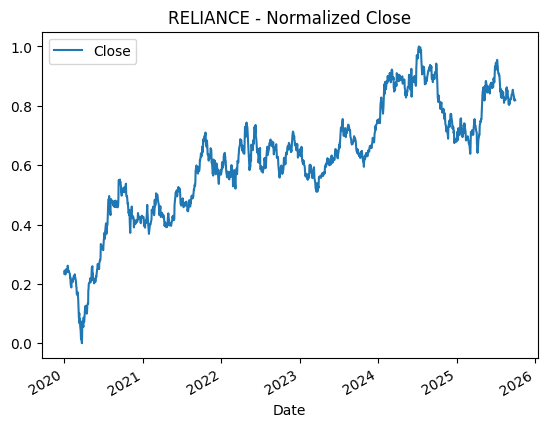

In [36]:
import matplotlib.pyplot as plt

sample_stock = 'RELIANCE'
normalized_df[normalized_df['stock_id'] == sample_stock][['Date', 'Close']].set_index('Date').plot(title=f'{sample_stock} - Normalized Close')
plt.show()

In [37]:
file_path = "E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/"
final_data.to_csv(f"{file_path}/04_normalization_model_input/normalized_model_input.csv", index=False)